In [1]:
import pandas as pd
import numpy as np
from pyjet import cluster,DTYPE_PTEPM
from sklearn import preprocessing
from scipy.stats import iqr
import tensorflow as tf

# Pre processing

In [2]:
path = '/anomalyvol/data/events_LHCO2020_backgroundMC_Pythia.h5'

In [3]:
df = pd.read_hdf(path,stop=10000) # just read first 10000 events

In [4]:
all_events = df.values

In [5]:
rows = all_events.shape[0]
cols = all_events.shape[1]
data = []

In [6]:
for i in range(rows):
    pseudojets_input = np.zeros(len([x for x in all_events[i][::3] if x > 0]), dtype=DTYPE_PTEPM)
    for j in range(cols // 3):
        if (all_events[i][j*3]>0):
            pseudojets_input[j]['pT'] = all_events[i][j*3]
            pseudojets_input[j]['eta'] = all_events[i][j*3+1]
            pseudojets_input[j]['phi'] = all_events[i][j*3+2]
        pass
    # cluster jets from the particles in one observation
    sequence = cluster(pseudojets_input, R=1.0, p=-1)
    jets = sequence.inclusive_jets()
    for k in range(len(jets)): # for each jet get (px, py, pz, e)
        jet = []
        jet.append(jets[k].px)
        jet.append(jets[k].py)
        jet.append(jets[k].pz)
        jet.append(jets[k].e)
        data.append(jet)

In [7]:
loaded_data = data
# data = loaded_data

In [8]:
data = np.array(data)
data.shape

(147331, 4)

In [9]:
# log transform pT
#data[:,3] = np.ma.log(data[:,3]).filled()

In [10]:
data

array([[-1.17658220e+03, -7.79040316e+02,  3.40962660e+02,
         1.45491963e+03],
       [ 6.11088616e+02,  7.16513394e+02,  1.55833044e+03,
         1.87194199e+03],
       [ 4.96094722e+02, -1.87111748e+01,  1.78940558e+03,
         1.85808569e+03],
       ...,
       [-1.43123397e-01,  7.72218759e-01, -5.37015154e+00,
         5.42727682e+00],
       [-2.31257017e-01, -6.81425110e-01,  1.42509806e+00,
         1.59647251e+00],
       [ 2.34250895e-01,  3.07633892e-01,  2.66273882e+01,
         2.66301955e+01]])

In [11]:
# splitting data
x_train = data[0:int(len(data) * 0.8)]
x_val = data[int(len(data) * 0.8):int(len(data) * 0.9)]
x_test = data[int(len(data) * 0.9):]

In [12]:
# regularize
scaler = preprocessing.StandardScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)
x_test = scaler.transform(x_test)

In [13]:
iqr_prop = iqr(x_train,axis = 0)
max_iqr = max(iqr_prop)
iqr_prop = np.array(iqr_prop) / max_iqr
print(iqr_prop)

[0.03069996 0.0303821  0.38396447 1.        ]


# VAE Model

In [14]:
import keras
from keras.layers import Lambda, Input, Dense, Flatten, Reshape, LeakyReLU, ELU
from keras.models import Model, Sequential
from keras import metrics, losses
from keras import backend as K

Using TensorFlow backend.


In [15]:
def sampling(args):
    """
    # Arguments
        args (tensor): mean and log of variance of Q(z|X)
    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [16]:
inter_dim_1 = 32
inter_dim_2 = 16
final_dim = 8
latent_dim = 2
input_dim = 4

In [17]:
# encoder
x = Input(shape=(input_dim,))
#x_flat = Flatten()(x)
h1 = Dense(inter_dim_1, activation='relu')(x)
h2 = Dense(inter_dim_2, activation='relu')(h1)
h3 = Dense(final_dim, activation='relu')(h2)
encoding = Dense(latent_dim, activation='tanh')(h3)

In [18]:
# decoder
decoder_h3 = Dense(final_dim, activation='relu')
decoder_h2 = Dense(inter_dim_2, activation='relu')
decoder_h1 = Dense(inter_dim_1, activation='relu')
decoder_mean = Dense(input_dim, activation='linear')

h3_decoded = decoder_h3(encoding)
h2_decoded = decoder_h2(h3_decoded)
h1_decoded = decoder_h1(h2_decoded)
x_decoded_mean = decoder_mean(h1_decoded)
# x_decoded = Reshape(input_shape)(x_decoded_mean)

In [19]:
vae = Model(inputs = x, outputs = x_decoded_mean, name = 'vae')

In [20]:
mse = keras.losses.MeanSquaredError()
def ae_loss(x, y):
    mse_loss = 0.25 * (iqr_prop[0]*(x[::,0] - y[::,0])**2 + iqr_prop[1]*(x[::,1] - y[::,1])**2 + iqr_prop[2]*(x[::,2] - y[::,2])**2 + iqr_prop[3]*(x[::,3] - y[::,3])**2)
    # mse_loss = mse(x,y)
    return mse_loss

vae.compile(optimizer='adam', loss=ae_loss)

In [21]:
vae.summary()

Model: "vae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 4)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                160       
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 18        
_________________________________________________________________
dense_5 (Dense)              (None, 8)                 24        
_________________________________________________________________
dense_6 (Dense)              (None, 16)                144     

# Train

In [22]:
from sklearn.model_selection import train_test_split

In [23]:
batch_size = 1000
epochs = 200

In [24]:
x_train.shape

(117864, 4)

In [25]:
my_callbacks = [
    keras.callbacks.EarlyStopping(patience=10)
]

In [26]:
hist = vae.fit(x_train, x_train,
               shuffle=True,
               epochs=epochs,
               batch_size=batch_size,
               validation_data=(x_val, x_val),
               callbacks=my_callbacks)

Train on 117864 samples, validate on 14733 samples
Epoch 1/200
117864/117864 [==============================] - 1s 7us/step - loss: 0.1768 - val_loss: 0.1126
Epoch 2/200
117864/117864 [==============================] - 0s 3us/step - loss: 0.0683 - val_loss: 0.0312
Epoch 3/200
117864/117864 [==============================] - 0s 3us/step - loss: 0.0227 - val_loss: 0.0183
Epoch 4/200
117864/117864 [==============================] - 0s 3us/step - loss: 0.0176 - val_loss: 0.0167
Epoch 5/200
117864/117864 [==============================] - 0s 3us/step - loss: 0.0166 - val_loss: 0.0161
Epoch 6/200
117864/117864 [==============================] - 0s 3us/step - loss: 0.0162 - val_loss: 0.0159
Epoch 7/200
117864/117864 [==============================] - 0s 3us/step - loss: 0.0160 - val_loss: 0.0157
Epoch 8/200
117864/117864 [==============================] - 0s 3us/step - loss: 0.0158 - val_loss: 0.0157
Epoch 9/200
117864/117864 [==============================] - 0s 3us/step - loss: 0.0158 - val

# Visualization

In [27]:
import matplotlib.pyplot as plt

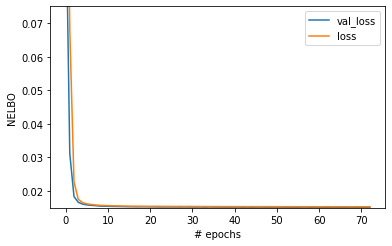

In [28]:
golden_size = lambda width: (width, 2. * width / (1 + np.sqrt(5)))

fig, ax = plt.subplots(figsize=golden_size(6))

hist_df = pd.DataFrame(hist.history)
hist_df.plot(ax=ax)

ax.set_ylabel('NELBO')
ax.set_xlabel('# epochs')

ax.set_ylim(.99*hist_df[1:].values.min(), 
            1.1*hist_df[1:].values.max())
plt.show()

In [29]:
predictions = vae.predict(x_test)

In [30]:
predictions

array([[ 0.00599492,  0.00701819,  0.04701798, -0.45887253],
       [ 0.00612069,  0.00638165,  0.02243845, -0.47782344],
       [-0.01159926,  0.01925661,  0.07538764,  1.5772469 ],
       ...,
       [ 0.00565313,  0.00689721, -0.00871535, -0.48582548],
       [ 0.00664479,  0.00600265,  0.00392516, -0.49163187],
       [ 0.0060753 ,  0.00717351,  0.05772662, -0.45149133]],
      dtype=float32)

In [31]:
distr = (x_test - predictions) / x_test

In [32]:
px_pred = [row[0] for row in predictions]
py_pred = [row[1] for row in predictions]
pz_pred = [row[2] for row in predictions]
e_pred = [row[3] for row in predictions]

In [33]:
px = [row[0] for row in x_test]
py = [row[1] for row in x_test]
pz = [row[2] for row in x_test]
e = [row[3] for row in x_test]

In [34]:
overall_distr = K.flatten(distr)
overall_pred = K.flatten(predictions)
overall_input = K.flatten(x_test)

(array([2.5000e+01, 3.1000e+01, 3.7000e+01, 4.0000e+01, 3.8000e+01,
        2.3000e+01, 3.8000e+01, 3.5000e+01, 5.6000e+01, 4.5000e+01,
        6.1000e+01, 6.7000e+01, 5.9550e+03, 2.6860e+03, 1.1200e+03,
        6.4200e+02, 4.9600e+02, 3.7100e+02, 3.5000e+02, 3.5500e+02,
        4.2100e+02, 5.7200e+02, 8.9500e+02, 2.5490e+03, 3.0651e+04,
        3.4210e+03, 1.2840e+03, 5.7800e+02, 2.6500e+02, 2.5300e+02,
        1.7200e+02, 1.4200e+02, 1.5000e+02, 1.0200e+02, 1.1900e+02,
        8.9000e+01, 8.1000e+01, 8.4000e+01, 8.1000e+01, 6.4000e+01,
        6.8000e+01, 5.9000e+01, 4.5000e+01, 5.8000e+01, 5.1000e+01,
        5.0000e+01, 5.7000e+01, 5.6000e+01, 4.6000e+01]),
 array([-1.        , -0.95918367, -0.91836735, -0.87755102, -0.83673469,
        -0.79591837, -0.75510204, -0.71428571, -0.67346939, -0.63265306,
        -0.59183673, -0.55102041, -0.51020408, -0.46938776, -0.42857143,
        -0.3877551 , -0.34693878, -0.30612245, -0.26530612, -0.2244898 ,
        -0.18367347, -0.14285714, -0.1

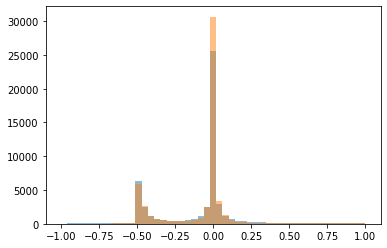

In [35]:
# overall pred vs input
bins = np.linspace(-1, 1, 50)
plt.hist(overall_input, bins=bins,alpha=0.5)
plt.hist(overall_pred, bins=bins,alpha=0.5)

(array([  148.,   177.,   172.,   212.,   203.,   240.,   246.,   258.,
          280.,   325.,   350.,   409.,   467.,  2136., 22285.,  1736.,
         1015.,  1561.,   896.,   779.,  1032.,  5299.,  1612.,   695.,
          552.,   446.,   363.,   337.,   338.]),
 array([-2.        , -1.86206897, -1.72413793, -1.5862069 , -1.44827586,
        -1.31034483, -1.17241379, -1.03448276, -0.89655172, -0.75862069,
        -0.62068966, -0.48275862, -0.34482759, -0.20689655, -0.06896552,
         0.06896552,  0.20689655,  0.34482759,  0.48275862,  0.62068966,
         0.75862069,  0.89655172,  1.03448276,  1.17241379,  1.31034483,
         1.44827586,  1.5862069 ,  1.72413793,  1.86206897,  2.        ]),
 <a list of 29 Patch objects>)

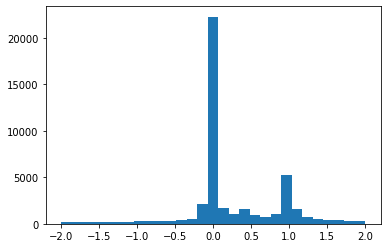

In [36]:
# overall distr
bins = np.linspace(-2, 2, 30)
plt.hist(overall_distr, bins=bins)

## Stacking output (orange) over input (blue) for pT, eta, phi, m

(array([0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.500e+01, 2.020e+02, 3.160e+02, 2.090e+02,
        5.630e+02, 3.879e+03, 8.524e+03, 3.370e+02, 2.190e+02, 1.560e+02,
        1.020e+02, 7.700e+01, 6.300e+01, 3.800e+01, 2.000e+01, 5.000e+00,
        3.000e+00, 2.000e+00, 2.000e+00, 2.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00]),
 array([-0.2       , -0.18974359, -0.17948718, -0.16923077, -0.15897436,
        -0.14871795, -0.13846154, -0.12820513, -0.11794872, -0.10769231,
        -0.0974359 , -0.08717949, -0.07692308, -0.06666667, -0.05641026,
        -0.04615385, -0.03589744, -0.02564103, -0.01538462, -0.00512821,
         0.00512821,  0.01538462,  0.02564103,  0.03589744,  0.04615385,
         0.05641026,  0.06666667,  0.07692308,  0.08717949,  0.0974359 ,
         0.10769231,  0.11794872,  0.12820513,  0.13846154,  0.14871795,
  

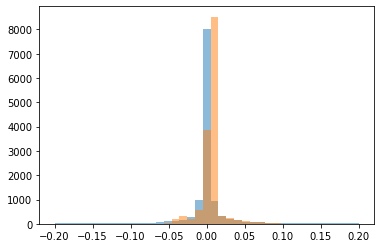

In [37]:
bins = np.linspace(-0.2, 0.2, 40)
plt.hist(px, bins=bins,alpha=0.5)
plt.hist(px_pred, bins=bins,alpha=0.5)

In [38]:
print(mse(px,px_pred))

tf.Tensor(0.95611954, shape=(), dtype=float32)


(array([1.0000e+00, 5.0000e+00, 9.0000e+00, 1.0000e+01, 1.3000e+01,
        1.7000e+01, 1.8000e+01, 3.0000e+01, 3.4000e+01, 4.2000e+01,
        3.2000e+01, 4.8000e+01, 5.3000e+01, 7.5000e+01, 8.0000e+01,
        9.3000e+01, 1.0500e+02, 1.1000e+02, 1.2600e+02, 1.6100e+02,
        1.1235e+04, 9.9800e+02, 5.0100e+02, 1.6300e+02, 1.4800e+02,
        1.2300e+02, 8.8000e+01, 7.2000e+01, 1.1700e+02, 1.1300e+02,
        6.1000e+01, 2.5000e+01, 1.2000e+01, 5.0000e+00, 0.0000e+00,
        1.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00]),
 array([-0.2       , -0.18974359, -0.17948718, -0.16923077, -0.15897436,
        -0.14871795, -0.13846154, -0.12820513, -0.11794872, -0.10769231,
        -0.0974359 , -0.08717949, -0.07692308, -0.06666667, -0.05641026,
        -0.04615385, -0.03589744, -0.02564103, -0.01538462, -0.00512821,
         0.00512821,  0.01538462,  0.02564103,  0.03589744,  0.04615385,
         0.05641026,  0.06666667,  0.07692308,  0.08717949,  0.0974359 ,
         0.10769231,  0.1179

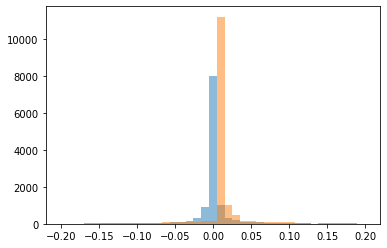

In [39]:
bins = np.linspace(-0.2, 0.2, 40)
plt.hist(py, bins=bins,alpha=0.5)
plt.hist(py_pred, bins=bins,alpha=0.5)

In [40]:
print(mse(py,py_pred))

tf.Tensor(1.0330703, shape=(), dtype=float32)


(array([  32.,   29.,   42.,   47.,   51.,   50.,   55.,   69.,   63.,
          64.,   93.,   93.,  152.,  172.,  203.,  298.,  368.,  704.,
        1313., 4022., 1340.,  707.,  442.,  287.,  204.,  145.,  127.,
         132.,   97.,   81.,   49.,   91.,   58.,   46.,   44.,   48.,
          35.,   43.,   30.]),
 array([-0.5       , -0.47435897, -0.44871795, -0.42307692, -0.3974359 ,
        -0.37179487, -0.34615385, -0.32051282, -0.29487179, -0.26923077,
        -0.24358974, -0.21794872, -0.19230769, -0.16666667, -0.14102564,
        -0.11538462, -0.08974359, -0.06410256, -0.03846154, -0.01282051,
         0.01282051,  0.03846154,  0.06410256,  0.08974359,  0.11538462,
         0.14102564,  0.16666667,  0.19230769,  0.21794872,  0.24358974,
         0.26923077,  0.29487179,  0.32051282,  0.34615385,  0.37179487,
         0.3974359 ,  0.42307692,  0.44871795,  0.47435897,  0.5       ]),
 <a list of 39 Patch objects>)

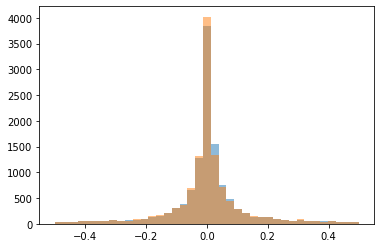

In [41]:
bins = np.linspace(-0.5, 0.5, 40)
plt.hist(pz, bins=bins,alpha=0.5)
plt.hist(pz_pred, bins=bins,alpha=0.5)

In [42]:
print(mse(pz,pz_pred))

tf.Tensor(0.0002295175, shape=(), dtype=float32)


(array([   0.,    0.,    0.,    0., 3602., 2988., 1558.,  832.,  517.,
         348.,  309.,  235.,  195.,  153.,  125.,  135.,  106.,  103.,
          78.,   61.,   70.,   52.,   81.,   45.,   51.,   48.,   57.,
          54.,   42.,   39.,   32.,   38.,   26.,   23.,   21.,   35.,
          27.,   24.,   13.]),
 array([-0.6       , -0.57692308, -0.55384615, -0.53076923, -0.50769231,
        -0.48461538, -0.46153846, -0.43846154, -0.41538462, -0.39230769,
        -0.36923077, -0.34615385, -0.32307692, -0.3       , -0.27692308,
        -0.25384615, -0.23076923, -0.20769231, -0.18461538, -0.16153846,
        -0.13846154, -0.11538462, -0.09230769, -0.06923077, -0.04615385,
        -0.02307692,  0.        ,  0.02307692,  0.04615385,  0.06923077,
         0.09230769,  0.11538462,  0.13846154,  0.16153846,  0.18461538,
         0.20769231,  0.23076923,  0.25384615,  0.27692308,  0.3       ]),
 <a list of 39 Patch objects>)

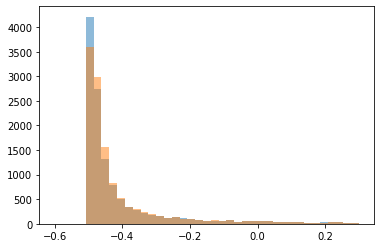

In [43]:
bins = np.linspace(-0.6,0.3, 40)
plt.hist(e, bins=bins,alpha=0.5)
plt.hist(e_pred, bins=bins,alpha=0.5)

In [44]:
print(mse(e,e_pred))

tf.Tensor(7.638296e-05, shape=(), dtype=float32)


In [45]:
d_px = [row[0] for row in distr]
d_py = [row[1] for row in distr]
d_pz = [row[2] for row in distr]
d_e = [row[3] for row in distr]

## Distribution of (input - output) / input

In [46]:
bins = np.linspace(-2, 2, 30)

(array([  58.,   74.,   63.,   82.,   70.,   75.,   83.,   85.,  104.,
          98.,   89.,  122.,  120.,  127.,  134.,  178.,  166.,  182.,
         239.,  316.,  480., 3132.,  826.,  369.,  278.,  207.,  181.,
         187.,  163.]),
 array([-2.        , -1.86206897, -1.72413793, -1.5862069 , -1.44827586,
        -1.31034483, -1.17241379, -1.03448276, -0.89655172, -0.75862069,
        -0.62068966, -0.48275862, -0.34482759, -0.20689655, -0.06896552,
         0.06896552,  0.20689655,  0.34482759,  0.48275862,  0.62068966,
         0.75862069,  0.89655172,  1.03448276,  1.17241379,  1.31034483,
         1.44827586,  1.5862069 ,  1.72413793,  1.86206897,  2.        ]),
 <a list of 29 Patch objects>)

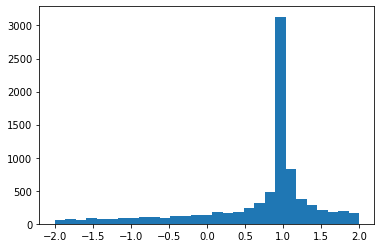

In [47]:
plt.hist(d_px, bins=bins)

(array([  77.,   93.,   86.,  101.,  102.,  130.,  117.,  112.,  105.,
         124.,  140.,  141.,  125.,  122.,  164.,  156.,  174.,  187.,
         218.,  277.,  412., 2087.,  729.,  290.,  230.,  205.,  164.,
         142.,  159.]),
 array([-2.        , -1.86206897, -1.72413793, -1.5862069 , -1.44827586,
        -1.31034483, -1.17241379, -1.03448276, -0.89655172, -0.75862069,
        -0.62068966, -0.48275862, -0.34482759, -0.20689655, -0.06896552,
         0.06896552,  0.20689655,  0.34482759,  0.48275862,  0.62068966,
         0.75862069,  0.89655172,  1.03448276,  1.17241379,  1.31034483,
         1.44827586,  1.5862069 ,  1.72413793,  1.86206897,  2.        ]),
 <a list of 29 Patch objects>)

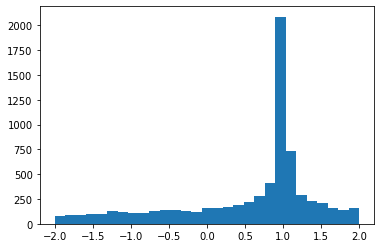

In [48]:
plt.hist(d_py, bins=bins)

(array([  13.,   10.,   23.,   27.,   29.,   34.,   43.,   57.,   67.,
         101.,  120.,  137.,  201., 1804., 7599., 1268.,  645., 1184.,
         435.,  178.,  133.,   79.,   54.,   35.,   42.,   33.,   18.,
           8.,   15.]),
 array([-2.        , -1.86206897, -1.72413793, -1.5862069 , -1.44827586,
        -1.31034483, -1.17241379, -1.03448276, -0.89655172, -0.75862069,
        -0.62068966, -0.48275862, -0.34482759, -0.20689655, -0.06896552,
         0.06896552,  0.20689655,  0.34482759,  0.48275862,  0.62068966,
         0.75862069,  0.89655172,  1.03448276,  1.17241379,  1.31034483,
         1.44827586,  1.5862069 ,  1.72413793,  1.86206897,  2.        ]),
 <a list of 29 Patch objects>)

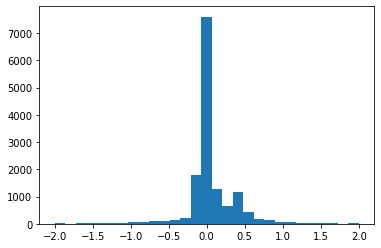

In [49]:
plt.hist(d_pz, bins=bins)

(array([0.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00, 2.0000e+00,
        1.0000e+00, 3.0000e+00, 4.0000e+00, 4.0000e+00, 2.0000e+00,
        1.0000e+00, 9.0000e+00, 2.1000e+01, 8.3000e+01, 1.4388e+04,
        1.3400e+02, 3.0000e+01, 8.0000e+00, 4.0000e+00, 8.0000e+00,
        7.0000e+00, 1.0000e+00, 3.0000e+00, 1.0000e+00, 2.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([-2.        , -1.86206897, -1.72413793, -1.5862069 , -1.44827586,
        -1.31034483, -1.17241379, -1.03448276, -0.89655172, -0.75862069,
        -0.62068966, -0.48275862, -0.34482759, -0.20689655, -0.06896552,
         0.06896552,  0.20689655,  0.34482759,  0.48275862,  0.62068966,
         0.75862069,  0.89655172,  1.03448276,  1.17241379,  1.31034483,
         1.44827586,  1.5862069 ,  1.72413793,  1.86206897,  2.        ]),
 <a list of 29 Patch objects>)

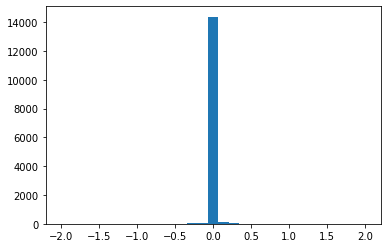

In [50]:
plt.hist(d_e, bins=bins)